In [1]:
using Random, Distributions,  XLSX, DataFrames, Plots,  CSV, QuasiMonteCarlo, HypothesisTests

# Quasi Monte Carlo (Stein, 1987):

Both Monte Carlo and Quasi Monte Carlo uses Analytical Inversion Method for sampling. The sampling is with bootstrap

## Asymptotic distribution properities:

- $h(.)$: function that is applied to random vector $X$
- $\hat{h}$: estimator of $E[\hat{h}]$

## Classic monte-carlo:

$var[\hat{h}] = N^{-1} var[h(X)]$

## Latin Hypercube:

$var[\hat{h}] = N^{-1} var[h(X)] + N^{-1} (N-1) cov[(h(X_1))(X_2)]$

### When $N \rightarrow \infty$, the covariance term is asymptotically non-positive:

$\underset{N \rightarrow \infty}{lim} N cov[(h(X_1))(X_2)] \leq 0$

For any square integrable $h(X)$, **proof with Jensen's inequality**

# Procedure (McKay et al., 1979)

- $F_k$: the cummulative distribution of X_k, where k indexes the kth component of X_j for jth simulated value
- $ \xi_{jk}$: the $NK$ iid $\sim U[0,1]$ random variables independent on $P$

Sampling procedure:

- $X_{jk}= F^{-1}_k[N^{-1}(p_{jk}-1+\xi_{jk})]$

# Insight

The amount of variance reduction increases with the degree of additivity in the random quantities on which the function we are simulating depends.

# Pseudo-algorithm

1. Stratify the probability density function into $Z$ intervals
2. Divide the cummulative curve into equal intervals
3. A sample is randomly taken from each interval or stratification

This function receives the charges of a cluster, a vector of the real cluster of the data, the dict of samples, the cluster that you want to analysis, the version of the cluster classification, and the size os the samples:
- **v0 - algorithm based**
- **v1 - smoker,**
- **v2 - smoker, BMI, age**

The idea is to return plots comparing the samples distributions and the real distribution.

In [2]:
function compare_dist(y::Vector{Float64}, real_cluster::Vector{Float64}, sample::Dict, cluster::Union{Float64,String}, version::String, n::Vector{Int64})

    #criando a distribuicao acumulada de ylabel
    ordered_y = sort(y)
    Fy = zeros(length(ordered_y))
    for i in 1:length(y) 
        Fy[i] = i/length(y)
    end

    if cluster != "base"
        prop_real = sum(real_cluster .== cluster) / length(real_cluster)
    end

    mc_p = plot(ordered_y, Fy, label = "data", legend = :topleft, colour = "black", linewidth = 1.5)
           title!("Monte Carlo Sampling")
    qmc_p = plot(ordered_y, Fy,label = "data", legend = :topleft, colour = "black", linewidth = 1.5)
            title!("QMC LatinHypercubeSample")
    j = 1

    mc_pvalue = zeros(length(n))
    qmc_pvalue = zeros(length(n))

    mc_prop = zeros(length(n))
    qmc_prop = zeros(length(n))

    for i in n

        if cluster != "base"
            mc_y = sort(sample["MC"]["value"][i][findall(j -> j == cluster,sample["MC"]["cluster"][version][i])])
            qmc_y = sort(sample["QMC"]["value"][i][findall(j -> j == cluster,sample["QMC"]["cluster"][version][i])])

            mc_pvalue[j] = pvalue(ApproximateTwoSampleKSTest(y, sample["MC"]["value"][i][findall(j -> j == cluster,sample["MC"]["cluster"][version][i])]))
            qmc_pvalue[j] = pvalue(ApproximateTwoSampleKSTest(y, sample["QMC"]["value"][i][findall(j -> j == cluster,sample["QMC"]["cluster"][version][i])]))
        else
            mc_y = sort(sample["MC"]["value"][i])
            qmc_y = sort(sample["QMC"]["value"][i])

            mc_pvalue[j] = pvalue(ApproximateTwoSampleKSTest(y, sample["MC"]["value"][i]))
            qmc_pvalue[j] = pvalue(ApproximateTwoSampleKSTest(y, sample["QMC"]["value"][i]))
        end

        mc_fy = zeros(length(mc_y))
        qmc_fy = zeros(length(qmc_y))

        for j in 1:length(mc_y)
            mc_fy[j] = j/length(mc_y)
        end

        for j in 1:length(qmc_y)
            qmc_fy[j] = j/length(qmc_y)
        end

        mc_p = plot!(mc_p, mc_y, mc_fy, label = "n = $i", legend = false)
        qmc_p = plot!(qmc_p, qmc_y, qmc_fy,label = "n = $i", legend = false)
       
        if cluster != "base"
            mc_prop[j] = sum(sample["MC"]["cluster"][version][i] .== cluster) / i
            qmc_prop[j] = sum(sample["QMC"]["cluster"][version][i] .== cluster) / i
        end

        j += 1
    end

    pvalue_p = plot(n, mc_pvalue, label = "MC")
               plot!(n, qmc_pvalue, label = "QMC", legend = :bottomright)
               title!("KS Test: P-value")

    if cluster != "base"
        prop_p = plot(n, mc_prop, label = "MC")
                plot!(n, qmc_prop, label = "QMC", legend = :bottomright)
                hline!(n, [prop_real], label = "Real Prop.", colour = "black")
                title!("Proportion convergence")
        
        return mc_p, qmc_p, pvalue_p, prop_p
    else
        return mc_p, qmc_p, pvalue_p, nothing
    end
end

compare_dist (generic function with 1 method)

### Read data and create the main matrix (data + k-means results) 

In [3]:
filePath = abspath(joinpath(pwd(), "..", ".."))
Pathread1 = string(filePath, "Databases\\Database.csv");
base_v1 = DataFrame(CSV.File(Pathread1));

Pathread2 = string(filePath, "Databases\\contracts.csv");
base_v2 = DataFrame(CSV.File(Pathread2));

dados = Matrix{Float64}(base_v1[:, [7, 10]])

# Charges || Cluster(K-means)

1338×2 Matrix{Float64}:
 16884.9   3.0
  1725.55  2.0
  4449.46  2.0
 21984.5   3.0
  3866.86  1.0
  3756.62  1.0
  8240.59  2.0
  7281.51  1.0
  6406.41  1.0
 28923.1   3.0
  2721.32  1.0
 27808.7   3.0
  1826.84  2.0
     ⋮     
  7050.02  1.0
  9377.9   2.0
 22395.7   3.0
 10325.2   2.0
 12629.2   1.0
 10795.9   1.0
 11411.7   2.0
 10600.5   2.0
  2205.98  1.0
  1629.83  2.0
  2007.94  1.0
 29141.4   3.0

In [4]:
describe(base_v1), describe(base_v2)

(12×7 DataFrame
 Row │ variable  mean          min        median      max        nmissing  elt ⋯
     │ Symbol    Union…        Any        Union…      Any        Int64     Dat ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ age       39.207        18         39.0        64                0  Int ⋯
   2 │ sex                     female                 male              0  Str
   3 │ bmi       30.6634       15.96      30.4        53.13             0  Flo
   4 │ children  1.09492       0          1.0         5                 0  Int
   5 │ smoker                  no                     yes               0  Str ⋯
   6 │ region                  northeast              southwest         0  Str
   7 │ charges   13270.4       1121.87    9382.03     63770.4           0  Flo
   8 │ PC1       -3.98286e-17  -1.47293   -0.33977    4.61339           0  Flo
   9 │ PC2       -5.31048e-17  -2.12482   -0.0404595  2.89304           0  Flo ⋯
  10 │ Cluster4  1.45366

#### Pre-allocations

In [5]:
ordered_y = sort(dados[:, 1])

Fy = zeros(length(ordered_y))
for i in 1:1338 
    Fy[i] = i/1338
end

sample = Dict()
sample["MC"] = Dict()
sample["QMC"] = Dict()
sample["MC"]["value"] = Dict()
sample["MC"]["cluster"] = Dict()
sample["MC"]["cluster"]["v0"] = Dict()
sample["MC"]["cluster"]["v1"] = Dict()
sample["MC"]["cluster"]["v2"] = Dict()
sample["QMC"]["value"] = Dict()
sample["QMC"]["cluster"] = Dict()
sample["QMC"]["cluster"]["v0"] = Dict()
sample["QMC"]["cluster"]["v1"] = Dict()
sample["QMC"]["cluster"]["v2"] = Dict()

Random.seed!(123)
seed_mc = rand(collect(1:1000), 20) #seeds used in the Monte carlo sampling
Random.seed!(321)
seed_qmc = rand(collect(1:1000), 20) #seeds used in the Quasi-Monte carlo sampling

n = collect(100:100:2000);

# Main loop

In [6]:
for j in 1:length(n)

    println("j = $j")
    MC_sample = zeros(n[j])
    MC_cluster_v0 = zeros(n[j]) #cluster by algorithm
    MC_cluster_v1 = zeros(n[j]) #cluster by smoker variable
    MC_cluster_v2 = zeros(n[j]) #cluster by smoder, BMI and age variables

    QMC_sample_latin = zeros(n[j])
    QMC_cluster_v0_latin = zeros(n[j])
    QMC_cluster_v1_latin = zeros(n[j])
    QMC_cluster_v2_latin = zeros(n[j])

    Random.seed!(seed_mc[j])
    MC_idx = rand(Uniform(minimum(Fy),1), n[j]) #Monte-Carlo sampling
    Random.seed!(seed_qmc[j])
    QMC_idx_latin = QuasiMonteCarlo.sample(n[j],minimum(Fy),1,LatinHypercubeSample()) #Quasi MonteCarlo
    
    for i in 1:n[j]
        mc_idx = maximum(findall(k -> k <= MC_idx[i], Fy)) #obtaining the index of sampled value in the real cumulative distribution 
        qmc_idx_latin = maximum(findall(k -> k <= QMC_idx_latin[i], Fy)) #obtaining the index of sampled value in the real cumulative distribution 

        MC_sample[i] = ordered_y[mc_idx] #obtaining the value sampled by Monte carlo
        MC_cluster_v0[i] = dados[findall(m -> m == MC_sample[i], dados[:, 1])[1],2] #obtaining the cluster of the sampled value by Monte carlo
        MC_cluster_v1[i] = base_v2[findall(m -> m == MC_sample[i], base_v2[:, 1])[1],7] #obtaining the cluster of the sampled value by Monte carlo
        MC_cluster_v2[i] = base_v2[findall(m -> m == MC_sample[i], base_v2[:, 1])[1],6] #obtaining the cluster of the sampled value by Monte carlo
    
        QMC_sample_latin[i] = ordered_y[qmc_idx_latin]
        QMC_cluster_v0_latin[i] = dados[findall(m -> m == QMC_sample_latin[i], dados[:, 1])[1],2] #obtaining the cluster of the sampled value by Quasi-Monte carlo
        QMC_cluster_v1_latin[i] = base_v2[findall(m -> m == QMC_sample_latin[i], base_v2[:, 1])[1],7] #obtaining the cluster of the sampled value by Quasi-Monte carlo
        QMC_cluster_v2_latin[i] = base_v2[findall(m -> m == QMC_sample_latin[i], base_v2[:, 1])[1],6] #obtaining the cluster of the sampled value by Quasi-Monte carlo
    end
    sample["MC"]["value"][n[j]] = MC_sample
    sample["MC"]["cluster"]["v0"][n[j]] = MC_cluster_v0
    sample["MC"]["cluster"]["v1"][n[j]] = MC_cluster_v1
    sample["MC"]["cluster"]["v2"][n[j]] = MC_cluster_v2
    sample["QMC"]["value"][n[j]] = QMC_sample_latin
    sample["QMC"]["cluster"]["v0"][n[j]] = QMC_cluster_v0_latin
    sample["QMC"]["cluster"]["v1"][n[j]] = QMC_cluster_v1_latin
    sample["QMC"]["cluster"]["v2"][n[j]] = QMC_cluster_v2_latin
end

#complete database
mc_base, qmc_base, pvalue_base, prop_base = compare_dist(dados[:, 1],dados[:, 2], sample, "base", "v0", n)

# V0 clustering
cluster0 = dados[findall(i -> i == 0.0, dados[:, 2]), :]
cluster1 = dados[findall(i -> i == 1.0, dados[:, 2]), :]
cluster2 = dados[findall(i -> i == 2.0, dados[:, 2]), :]
cluster3 = dados[findall(i -> i == 3.0, dados[:, 2]), :]

mc_c0, qmc_c0, c0_pvalue, c0_prop = compare_dist(cluster0[:, 1],dados[:, 2], sample, 0.0, "v0", n)
mc_c1, qmc_c1, c1_pvalue, c1_prop= compare_dist(cluster1[:, 1],dados[:, 2], sample, 1.0,"v0", n)
mc_c2, qmc_c2, c2_pvalue, c2_prop = compare_dist(cluster2[:, 1],dados[:, 2], sample, 2.0, "v0", n)
mc_c3, qmc_c3, c3_pvalue, c3_prop = compare_dist(cluster3[:, 1], dados[:, 2],sample, 3.0, "v0", n)

#v1 clustering
cluster0 = Matrix{Float64}(base_v2[findall(i -> i == 0.0, base_v2[:, 7]), [1,7]])
cluster1 = Matrix{Float64}(base_v2[findall(i -> i == 1.0, base_v2[:, 7]), [1,7]])

mc_c0, qmc_c0, c0_pvalue, c0_prop = compare_dist(cluster0[:, 1],Vector{Float64}(base_v2[:, 7]), sample, 0.0, "v1", n)
mc_c1, qmc_c1, c1_pvalue, c1_prop= compare_dist(cluster1[:, 1],Vector{Float64}(base_v2[:, 7]), sample, 1.0,"v1", n)

#v2 clustering
cluster0 = Matrix{Float64}(base_v2[findall(i -> i == 0.0, base_v2[:, 6]), [1,6]])
cluster1 = Matrix{Float64}(base_v2[findall(i -> i == 1.0, base_v2[:, 6]), [1,6]])
cluster2 = Matrix{Float64}(base_v2[findall(i -> i == 2.0, base_v2[:, 6]), [1,6]])
cluster3 = Matrix{Float64}(base_v2[findall(i -> i == 3.0, base_v2[:, 6]), [1,6]])
cluster4 = Matrix{Float64}(base_v2[findall(i -> i == 4.0, base_v2[:, 6]), [1,6]])
cluster5 = Matrix{Float64}(base_v2[findall(i -> i == 5.0, base_v2[:, 6]), [1,6]])
cluster6 = Matrix{Float64}(base_v2[findall(i -> i == 6.0, base_v2[:, 6]), [1,6]])
cluster7 = Matrix{Float64}(base_v2[findall(i -> i == 7.0, base_v2[:, 6]), [1,6]])


mc_c0, qmc_c0, c0_pvalue, c0_prop = compare_dist(cluster0[:, 1],Vector{Float64}(base_v2[:, 6]), sample, 0.0, "v2", n)
mc_c1, qmc_c1, c1_pvalue, c1_prop= compare_dist(cluster1[:, 1],Vector{Float64}(base_v2[:, 6]), sample, 1.0,"v2", n)
mc_c2, qmc_c2, c2_pvalue, c2_prop = compare_dist(cluster2[:, 1],Vector{Float64}(base_v2[:, 6]), sample, 2.0, "v2", n)
mc_c3, qmc_c3, c3_pvalue, c3_prop = compare_dist(cluster3[:, 1],Vector{Float64}(base_v2[:, 6]), sample, 3.0,"v2", n)
mc_c4, qmc_c4, c4_pvalue, c4_prop = compare_dist(cluster4[:, 1],Vector{Float64}(base_v2[:, 6]), sample, 4.0, "v2", n)
mc_c5, qmc_c5, c5_pvalue, c5_prop = compare_dist(cluster5[:, 1],Vector{Float64}(base_v2[:, 6]), sample, 5.0,"v2", n)
mc_c6, qmc_c6, c6_pvalue, c6_prop = compare_dist(cluster6[:, 1],Vector{Float64}(base_v2[:, 6]), sample, 6.0, "v2", n)
mc_c7, qmc_c7, c7_pvalue, c7_prop = compare_dist(cluster7[:, 1],Vector{Float64}(base_v2[:, 6]), sample, 7.0,"v2", n)

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

j = 1
j = 2
j = 3
j = 4
j = 5
j = 6
j = 7
j = 8
j = 9
j = 10
j = 11
j = 12
j = 13
j = 14
j = 15
j = 16
j = 17
j = 18
j = 19
j = 20


┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

(Plot{Plots.GRBackend() n=21}, Plot{Plots.GRBackend() n=21}, Plot{Plots.GRBackend() n=2}, Plot{Plots.GRBackend() n=3})

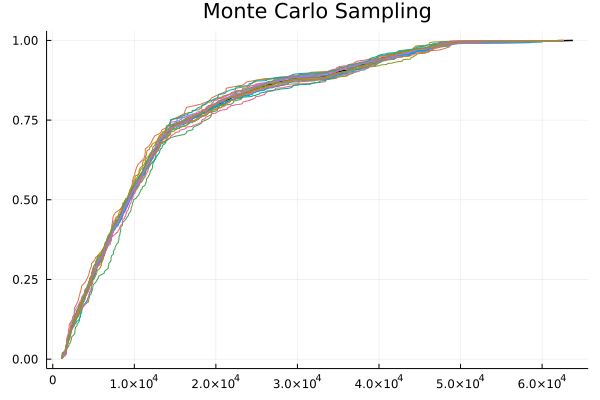

In [13]:
mc_base

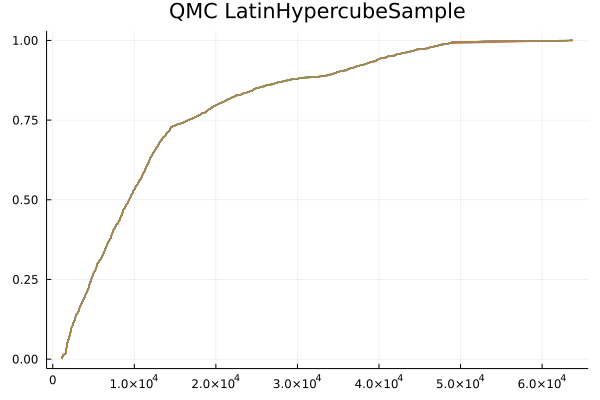

In [8]:
qmc_base

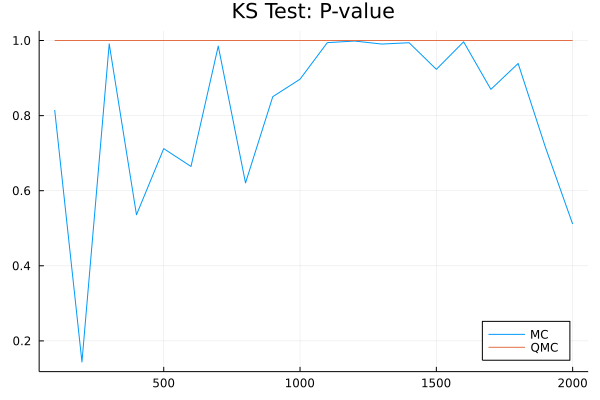

In [9]:
pvalue_base

# for Cluster 0

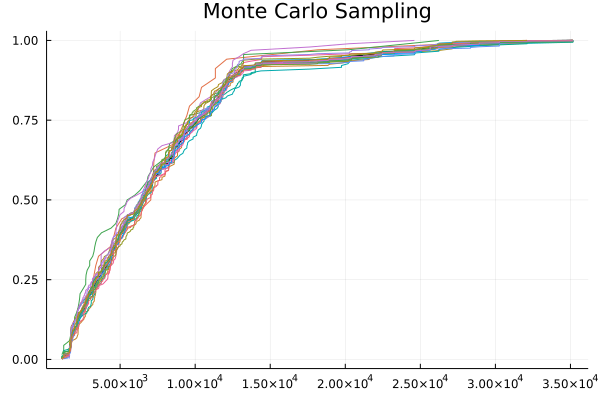

In [14]:
mc_c0

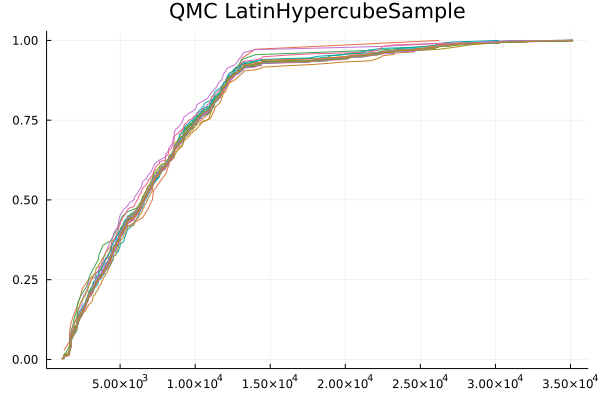

In [16]:
qmc_c0

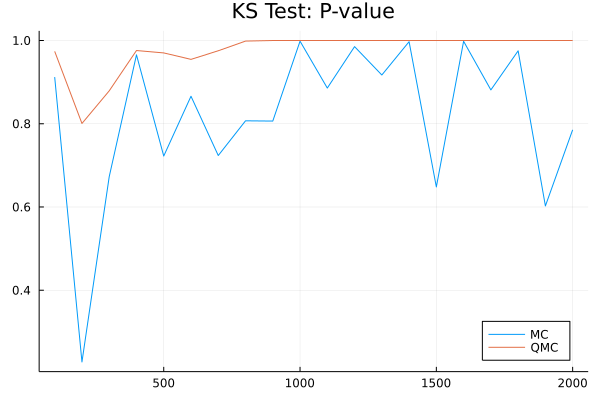

In [17]:
c0_pvalue

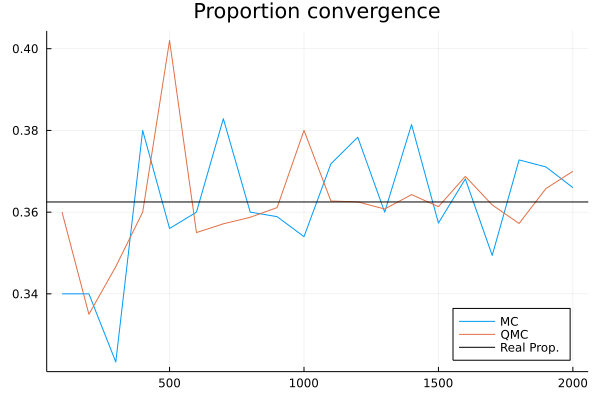

In [18]:
c0_prop

### Checking if the distributions of each cluster differ from other using KS-test

In [11]:
cst = Vector{Float64}(collect(0:7))
p_value = Matrix{Any}(zeros(9,9))
p_value[1,2:end] = ["Cluster 0","Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7"]
p_value[2:end,1] = ["Cluster 0","Cluster 1","Cluster 2","Cluster 3","Cluster 4","Cluster 5","Cluster 6","Cluster 7"]

m = 0
n = 0
for i in cst
    m +=1
    for j in cst
        n+=1
        x = base_v2[findall(k -> k == i, base_v2[:, 6]), [1]][:, 1]
        y = base_v2[findall(k -> k == j, base_v2[:, 6]), [1]][:, 1]
        p_value[m+1,n+1] = round(pvalue(ApproximateTwoSampleKSTest(x, y)), digits = 5)
    end
    n = 0
end

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\Dvf6v\src\kolmogorov_smirnov.jl:167
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests C:\Users\xx-re\.julia\packages\HypothesisTests\

In [12]:
DataFrame(p_value[2:end,:], ["Cluster", "Cluster 0", "Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4", "Cluster 5", "Cluster 6", "Cluster 7"])

,Cluster,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6
,Any,Any,Any,Any,Any,Any,Any,Any
1,Cluster 0,1.0,0.0,0.10395,0.0,0.0,0.0,0.0
2,Cluster 1,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,Cluster 2,0.10395,0.0,1.0,0.0,0.0,0.0,0.0
4,Cluster 3,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,Cluster 4,0.0,0.0,0.0,0.0,1.0,2.0e-5,0.93581
6,Cluster 5,0.0,0.0,0.0,0.0,2.0e-5,1.0,0.0
7,Cluster 6,0.0,0.0,0.0,0.0,0.93581,0.0,1.0
8,Cluster 7,0.0,0.0,0.0,0.0,0.0,4.0e-5,0.0
